# CA2: PlaneSimple 

## 1. Business Understanding




A new airline company, PlaneSimple, is looking to see if it can benefit from machine learning, and has tasked you with performing several analyses.

## 2. Data Understanding

### Library Imports

In [150]:
# Import Libraries Required
import warnings
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller,grangercausalitytests,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pylab import rcParams
import pylab
from pandas.plotting import lag_plot
from datetime import datetime,date, timedelta
import os
from collections import Counter
import logging
import time
import pickle

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,month_plot,quarter_plot
from statsmodels.tools.eval_measures import mse,rmse,meanabs

import pmdarima as pm
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sweetviz as sv

from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
import re

import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Data Collection

In [151]:
# reads the data from the file
df = pd.read_csv('Tweets.csv', encoding="ISO-8859-1")

### Data Description

In [152]:
# show the top 5 rows
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [153]:
# Get the size of the data set
print("Data set size:", df.shape)

# Get the number of observations and the names and data types of the columns
print(df.info())

Data set size: (14640, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 146

In [154]:
# show descriptive statistics
df.describe()

tweet_id  airline_sentiment_confidence  negativereason_confidence  \
count  1.464000e+04                  14640.000000               10522.000000   
mean   5.692184e+17                      0.900169                   0.638298   
std    7.791112e+14                      0.162830                   0.330440   
min    5.675883e+17                      0.335000                   0.000000   
25%    5.685592e+17                      0.692300                   0.360600   
50%    5.694779e+17                      1.000000                   0.670600   
75%    5.698905e+17                      1.000000                   1.000000   
max    5.703106e+17                      1.000000                   1.000000   

       retweet_count  
count   14640.000000  
mean        0.082650  
std         0.745778  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        44.000000

In [155]:
# show descriptive statistics transposed
df.describe().T

count          mean           std  \
tweet_id                      14640.0  5.692184e+17  7.791112e+14   
airline_sentiment_confidence  14640.0  9.001689e-01  1.628300e-01   
negativereason_confidence     10522.0  6.382983e-01  3.304398e-01   
retweet_count                 14640.0  8.265027e-02  7.457782e-01   

                                       min           25%           50%  \
tweet_id                      5.675883e+17  5.685592e+17  5.694779e+17   
airline_sentiment_confidence  3.350000e-01  6.923000e-01  1.000000e+00   
negativereason_confidence     0.000000e+00  3.606000e-01  6.706000e-01   
retweet_count                 0.000000e+00  0.000000e+00  0.000000e+00   

                                       75%           max  
tweet_id                      5.698905e+17  5.703106e+17  
airline_sentiment_confidence  1.000000e+00  1.000000e+00  
negativereason_confidence     1.000000e+00  1.000000e+00  
retweet_count                 0.000000e+00  4.400000e+01

In [156]:
# show column names
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [157]:
# select columns that are objects
df.select_dtypes(include=['object']).columns

Index(['airline_sentiment', 'negativereason', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold', 'text',
       'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')

In [158]:
# select columns that are integers
df.select_dtypes(include=['int']).columns

Index(['tweet_id', 'retweet_count'], dtype='object')

##### Tweets created Range

In [159]:
# let's explore years of birth
print("The first tweet was created on:", min(df['tweet_created']))
print("The last tweet was created on:", max(df['tweet_created']))

The first tweet was created on: 2015-02-16 23:36:05 -0800
The last tweet was created on: 2015-02-24 11:53:37 -0800


##### Missing Values  

In [160]:
# percentage of total missing values per column
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(df)

Your selected dataframe has 15 columns.
There are 7 columns that have missing values.


Missing Values  % of Total Values
negativereason_gold                 14608               99.8
airline_sentiment_gold              14600               99.7
tweet_coord                         13621               93.0
negativereason                       5462               37.3
user_timezone                        4820               32.9
tweet_location                       4733               32.3
negativereason_confidence            4118               28.1

##### Zero Values

In [161]:
# percentage of 0 values in each column
values_tot = len(df.index)
df[df == 0].count()/values_tot

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.000000
negativereason_confidence       0.091803
airline                         0.000000
airline_sentiment_gold          0.000000
name                            0.000000
negativereason_gold             0.000000
retweet_count                   0.947609
text                            0.000000
tweet_coord                     0.000000
tweet_created                   0.000000
tweet_location                  0.000000
user_timezone                   0.000000
dtype: float64

##### Duplicates

In [162]:
# Review how many duplicates are in the dataframe
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (36, 15)


##### Outliers

In [163]:
# Check for outliers
num_cols = ['tweet_id', 'retweet_count']
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f'{col}: {len(outliers)} outliers')

tweet_id: 0 outliers
retweet_count: 767 outliers


#### Nan Values

In [164]:
# count number of NaNs
df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [165]:
#Display data with any missing values
df.loc[df.isnull().any(axis=1)]

tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                        1.0000   
1      570301130888122368          positive                        0.3486   
2      570301083672813571           neutral                        0.6837   
3      570301031407624196          negative                        1.0000   
4      570300817074462722          negative                        1.0000   
...                   ...               ...                           ...   
14635  569587686496825344          positive                        0.3487   
14636  569587371693355008          negative                        1.0000   
14637  569587242672398336           neutral                        1.0000   
14638  569587188687634433          negative                        1.0000   
14639  569587140490866689           neutral                        0.6771   

               negativereason  negativereason_confidence         airline  \
0                         NaN                        NaN  Virgin America   
1                         NaN                     0.0000  Virgin America   
2                         NaN                        NaN  Virgin America   
3                  Bad Flight                     0.7033  Virgin America   
4                  Can't Tell                     1.0000  Virgin America   
...                       ...                        ...             ...   
14635                     NaN                     0.0000        American   
14636  Customer Service Issue                     1.0000        American   
14637                     NaN                        NaN        American   
14638  Customer Service Issue                     0.6659        American   
14639                     NaN                     0.0000        American   

      airline_sentiment_gold             name negativereason_gold  \
0                        NaN          cairdin                 NaN   
1                        NaN         jnardino                 NaN   
2                        NaN       yvonnalynn                 NaN   
3                        NaN         jnardino                 NaN   
4                        NaN         jnardino                 NaN   
...                      ...              ...                 ...   
14635                    NaN  KristenReenders                 NaN   
14636                    NaN         itsropes                 NaN   
14637                    NaN         sanyabun                 NaN   
14638                    NaN       SraJackson                 NaN   
14639                    NaN        daviddtwu                 NaN   

       retweet_count                                               text  \
0                  0                @VirginAmerica What @dhepburn said.   
1                  0  @VirginAmerica plus you've added commercials t...   
2                  0  @VirginAmerica I didn't today... Must mean I n...   
3                  0  @VirginAmerica it's really aggressive to blast...   
4                  0  @VirginAmerica and it's a really big bad thing...   
...              ...                                                ...   
14635              0  @AmericanAir thank you we got on a different f...   
14636              0  @AmericanAir leaving over 20 minutes Late Flig...   
14637              0  @AmericanAir Please bring American Airlines to...   
14638              0  @AmericanAir you have my money, you change my ...   
14639              0  @AmericanAir we have 8 ppl so we need 2 know h...   

      tweet_coord              tweet_created tweet_location  \
0             NaN  2015-02-24 11:35:52 -0800            NaN   
1             NaN  2015-02-24 11:15:59 -0800            NaN   
2             NaN  2015-02-24 11:15:48 -0800      Lets Play   
3             NaN  2015-02-24 11:15:36 -0800            NaN   
4             NaN  2015-02-24 11:14:45 -0800            NaN   
...           ...                        ...            ...   
14635   

#### Unique Values

In [166]:
# Displays total number of unique values in each column.
df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

##### Unique Values for Category Data

In [167]:
# unique values for 'airline_sentiment'
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [168]:
# unique values for 'negativereason_confidence'
df['negativereason_confidence'].unique()

array([   nan, 0.    , 0.7033, ..., 0.6234, 0.644 , 0.7255])

In [169]:
# unique values for 'tweet_coord'
df['tweet_coord'].unique()

array([nan, '[40.74804263, -73.99295302]', '[42.361016, -71.02000488]',
       '[33.94540417, -118.4062472]', '[33.94209449, -118.40410103]',
       '[33.2145038, -96.9321504]', '[34.0219817, -118.38591198]',
       '[33.57963333, -117.73024772]', '[40.6413712, -73.78311558]',
       '[36.08457854, -115.13780136]', '[0.0, 0.0]',
       '[37.79374402, -122.39327564]', '[26.074379, -80.1416831]',
       '[33.9469039, -118.40716847]', '[51.04345575, -114.06071363]',
       '[40.64662464, -73.77090177]', '[33.94652852, -118.40766257]',
       '[38.9128188, -77.00798226]', '[32.84359605, -96.84910929]',
       '[32.8437698, -96.84928399]', '[26.06726717, -80.14433663]',
       '[32.8454782, -96.8504585]', '[39.24087254, -94.63994975]',
       '[37.77465018, -122.44032176]', '[33.94696831, -118.40747994]',
       '[40.63767372, -74.11075451]', '[40.78986648, -73.10068286]',
       '[42.5696777, -71.42056878]', '[37.80065252, -122.43857414]',
       '[36.08546367, -115.31814055]', '[19.437066

In [170]:
# unique values for 'tweet_location'
df['tweet_location'].unique()

array([nan, 'Lets Play', 'San Francisco CA', ..., 'Columbus, OH, USA',
       'Milwaukee County, Wisconsin', 'Nigeria,lagos'], dtype=object)

In [171]:
# unique values for 'user_timezone'
df['user_timezone'].unique() 

array(['Eastern Time (US & Canada)', 'Pacific Time (US & Canada)',
       'Central Time (US & Canada)', 'America/New_York',
       'Atlantic Time (Canada)', 'Quito', nan,
       'Mountain Time (US & Canada)', 'Vienna', 'Caracas', 'Kuala Lumpur',
       'Brisbane', 'Arizona', 'London', 'Tehran', 'Alaska', 'Sydney',
       'Irkutsk', 'Santiago', 'Amsterdam', 'Tijuana', 'Abu Dhabi',
       'Central America', 'Edinburgh', 'Jerusalem', 'Hawaii', 'Paris',
       'Guam', 'New Delhi', 'Stockholm', 'America/Chicago', 'Berlin',
       'Madrid', 'Athens', 'Brussels', 'Taipei', 'Rome', 'Beijing',
       'Mexico City', 'Bern', 'Singapore', 'Indiana (East)', 'Melbourne',
       'Saskatchewan', 'Casablanca', 'Brasilia', 'Kyiv', 'Bucharest',
       'Greenland', 'Prague', 'New Caledonia', 'Bogota', 'Seoul',
       'Sarajevo', 'Wellington', 'Bangkok', 'Warsaw', 'Copenhagen',
       'Hong Kong', 'Guadalajara', 'Mid-Atlantic', 'Mazatlan',
       'Buenos Aires', 'America/Los_Angeles', 'Dublin', 'Lisbon',
 

In [172]:
# unique values for 'airline_sentiment_gold'
df['airline_sentiment_gold'].unique()

array([nan, 'negative', 'neutral', 'positive'], dtype=object)

In [173]:
# unique values for 'airline'
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [174]:
# unique values for 'negativereason'
df['negativereason'].unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [175]:
# unique values for 'negativereason_gold'
df['negativereason_gold'].unique()

array([nan, 'Late Flight\nFlight Attendant Complaints',
       'Late Flight\nLost Luggage', 'Late Flight',
       'Customer Service Issue', "Can't Tell",
       'Cancelled Flight\nCustomer Service Issue', 'Cancelled Flight',
       'Bad Flight', 'Lost Luggage\nDamaged Luggage',
       'Late Flight\nCancelled Flight', 'Flight Attendant Complaints',
       'Customer Service Issue\nLost Luggage',
       "Customer Service Issue\nCan't Tell"], dtype=object)

## 3. Exploritory Data Analysis(EDA) 

#### Data Cleaning

In [176]:
# Replace NaN values in 'airline_sentiment_gold' with a 'neutral'
df['airline_sentiment_gold'].fillna('neutral', inplace=True)

In [177]:
# Replace NaN values in 'negativereason' with a 'no comment'
df['negativereason'].fillna('no comment', inplace=True)

In [178]:
# Replace NaN values in 'negativereason_gold' with a 'no comment'
df['negativereason_gold'].fillna('no comment', inplace=True)

In [179]:
# Replace NaN values in 'negativereason_confidence' with a 0
df['negativereason_confidence'].fillna(0, inplace=True)

In [180]:
# re-checking the count number of NaNs
df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                      0
negativereason_confidence           0
airline                             0
airline_sentiment_gold              0
name                                0
negativereason_gold                 0
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

As location is not something required for this project I will drop the remaining columns.

##### Dropping Columns

In [181]:
# Drop 'tweet_coord','tweet_location' & 'user_timezone' from the DataFrame
columns_to_drop = ['tweet_coord','tweet_location','user_timezone']
df.drop(columns_to_drop, axis=1, inplace=True)

In [182]:
# calling top 5 rows to review changes
df.head(5)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0     no comment                     0.0000  Virgin America   
1     no comment                     0.0000  Virgin America   
2     no comment                     0.0000  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                neutral     cairdin          no comment              0   
1                neutral    jnardino          no comment              0   
2                neutral  yvonnalynn          no comment              0   
3                neutral    jnardino          no comment              0   
4                neutral    jnardino          no comment              0   

                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

               tweet_created  
0  2015-02-24 11:35:52 -0800  
1  2015-02-24 11:15:59 -0800  
2  2015-02-24 11:15:48 -0800  
3  2015-02-24 11:15:36 -0800  
4  2015-02-24 11:14:45 -0800

#### Changing Data Types

In [183]:
# changing 'tweet_created' data type
df["tweet_created"] = pd.to_datetime(df["tweet_created"])

In [184]:
# review datatype changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype                    
---  ------                        --------------  -----                    
 0   tweet_id                      14640 non-null  int64                    
 1   airline_sentiment             14640 non-null  object                   
 2   airline_sentiment_confidence  14640 non-null  float64                  
 3   negativereason                14640 non-null  object                   
 4   negativereason_confidence     14640 non-null  float64                  
 5   airline                       14640 non-null  object                   
 6   airline_sentiment_gold        14640 non-null  object                   
 7   name                          14640 non-null  object                   
 8   negativereason_gold           14640 non-null  object                   
 9   retweet_count                 14640 non

In [185]:
df["tweet_created"]

0       2015-02-24 11:35:52-08:00
1       2015-02-24 11:15:59-08:00
2       2015-02-24 11:15:48-08:00
3       2015-02-24 11:15:36-08:00
4       2015-02-24 11:14:45-08:00
                   ...           
14635   2015-02-22 12:01:01-08:00
14636   2015-02-22 11:59:46-08:00
14637   2015-02-22 11:59:15-08:00
14638   2015-02-22 11:59:02-08:00
14639   2015-02-22 11:58:51-08:00
Name: tweet_created, Length: 14640, dtype: datetime64[ns, UTC-08:00]

#### Feature Creation

In [186]:
# Split the tweet created column into date and time columns
df['tweet_date'] = df['tweet_created'].dt.date
df['tweet_time'] = df['tweet_created'].dt.time
df

tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                        1.0000   
1      570301130888122368          positive                        0.3486   
2      570301083672813571           neutral                        0.6837   
3      570301031407624196          negative                        1.0000   
4      570300817074462722          negative                        1.0000   
...                   ...               ...                           ...   
14635  569587686496825344          positive                        0.3487   
14636  569587371693355008          negative                        1.0000   
14637  569587242672398336           neutral                        1.0000   
14638  569587188687634433          negative                        1.0000   
14639  569587140490866689           neutral                        0.6771   

               negativereason  negativereason_confidence         airline  \
0                  no comment                     0.0000  Virgin America   
1                  no comment                     0.0000  Virgin America   
2                  no comment                     0.0000  Virgin America   
3                  Bad Flight                     0.7033  Virgin America   
4                  Can't Tell                     1.0000  Virgin America   
...                       ...                        ...             ...   
14635              no comment                     0.0000        American   
14636  Customer Service Issue                     1.0000        American   
14637              no comment                     0.0000        American   
14638  Customer Service Issue                     0.6659        American   
14639              no comment                     0.0000        American   

      airline_sentiment_gold             name negativereason_gold  \
0                    neutral          cairdin          no comment   
1                    neutral         jnardino          no comment   
2                    neutral       yvonnalynn          no comment   
3                    neutral         jnardino          no comment   
4                    neutral         jnardino          no comment   
...                      ...              ...                 ...   
14635                neutral  KristenReenders          no comment   
14636                neutral         itsropes          no comment   
14637                neutral         sanyabun          no comment   
14638                neutral       SraJackson          no comment   
14639                neutral        daviddtwu          no comment   

       retweet_count                                               text  \
0                  0                @VirginAmerica What @dhepburn said.   
1                  0  @VirginAmerica plus you've added commercials t...   
2                  0  @VirginAmerica I didn't today... Must mean I n...   
3                  0  @VirginAmerica it's really aggressive to blast...   
4                  0  @VirginAmerica and it's a really big bad thing...   
...              ...                                                ...   
14635              0  @AmericanAir thank you we got on a different f...   
14636              0  @AmericanAir leaving over 20 minutes Late Flig...   
14637              0  @AmericanAir Please bring American Airlines to...   
14638              0  @AmericanAir you have my money, you change my ...   
14639              0  @AmericanAir we have 8 ppl so we need 2 know h...   

                  tweet_created  tweet_date tweet_time  
0     2015-02-24 11:35:52-08:00  2015-02-24   11:35:52  
1     2015-02-24 11:15:59-08:00  2015-02-24   11:15:59  
2     2015-02-24 11:15:48-08:00  2015-02-24   11:15:48  
3     2015-02-24 11:15:36-08:00  2015-02-24   11:15:36  
4     2015-02-24 11:14:45-08:00  2015-02-24   11:14:45  
...                         ...         ...        ...  
14635 2015-02-22 12:01:01-08:00  2015-02-22   12:0

In [187]:
# Mapping the sentiment values to corresponding scores
sentiment_scores = {
    'neutral': 0,
    'negative': -1,
    'positive': 1
}

# Adding a new column 'Score' based on 'airline_sentiment'
df['Score'] = df['airline_sentiment'].map(sentiment_scores)
df

tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                        1.0000   
1      570301130888122368          positive                        0.3486   
2      570301083672813571           neutral                        0.6837   
3      570301031407624196          negative                        1.0000   
4      570300817074462722          negative                        1.0000   
...                   ...               ...                           ...   
14635  569587686496825344          positive                        0.3487   
14636  569587371693355008          negative                        1.0000   
14637  569587242672398336           neutral                        1.0000   
14638  569587188687634433          negative                        1.0000   
14639  569587140490866689           neutral                        0.6771   

               negativereason  negativereason_confidence         airline  \
0                  no comment                     0.0000  Virgin America   
1                  no comment                     0.0000  Virgin America   
2                  no comment                     0.0000  Virgin America   
3                  Bad Flight                     0.7033  Virgin America   
4                  Can't Tell                     1.0000  Virgin America   
...                       ...                        ...             ...   
14635              no comment                     0.0000        American   
14636  Customer Service Issue                     1.0000        American   
14637              no comment                     0.0000        American   
14638  Customer Service Issue                     0.6659        American   
14639              no comment                     0.0000        American   

      airline_sentiment_gold             name negativereason_gold  \
0                    neutral          cairdin          no comment   
1                    neutral         jnardino          no comment   
2                    neutral       yvonnalynn          no comment   
3                    neutral         jnardino          no comment   
4                    neutral         jnardino          no comment   
...                      ...              ...                 ...   
14635                neutral  KristenReenders          no comment   
14636                neutral         itsropes          no comment   
14637                neutral         sanyabun          no comment   
14638                neutral       SraJackson          no comment   
14639                neutral        daviddtwu          no comment   

       retweet_count                                               text  \
0                  0                @VirginAmerica What @dhepburn said.   
1                  0  @VirginAmerica plus you've added commercials t...   
2                  0  @VirginAmerica I didn't today... Must mean I n...   
3                  0  @VirginAmerica it's really aggressive to blast...   
4                  0  @VirginAmerica and it's a really big bad thing...   
...              ...                                                ...   
14635              0  @AmericanAir thank you we got on a different f...   
14636              0  @AmericanAir leaving over 20 minutes Late Flig...   
14637              0  @AmericanAir Please bring American Airlines to...   
14638              0  @AmericanAir you have my money, you change my ...   
14639              0  @AmericanAir we have 8 ppl so we need 2 know h...   

                  tweet_created  tweet_date tweet_time  Score  
0     2015-02-24 11:35:52-08:00  2015-02-24   11:35:52      0  
1     2015-02-24 11:15:59-08:00  2015-02-24   11:15:59      1  
2     2015-02-24 11:15:48-08:00  2015-02-24   11:15:48      0  
3     2015-02-24 11:15:36-08:00  2015-02-24   11:15:36     -1  
4     2015-02-24 11:14:45-08:00  2015-02-24   11:14:45     -1  
...                         ...         ...        ...    ...  
1

In [188]:
df['tweet_date'].unique()

array([datetime.date(2015, 2, 24), datetime.date(2015, 2, 23),
       datetime.date(2015, 2, 22), datetime.date(2015, 2, 21),
       datetime.date(2015, 2, 20), datetime.date(2015, 2, 19),
       datetime.date(2015, 2, 18), datetime.date(2015, 2, 17),
       datetime.date(2015, 2, 16)], dtype=object)

## 4. Machine Learning

### **Part 1: Time Series - Forecasting Airline Interest** 

#### **a.	Briefly explain why Time Series may be useful in this situation and describe your analysis objective.**

Time series analysis would be useful in this situation because it allows us to analyze and model data collected over time, where the observations are dependent on previous values and exhibit temporal patterns. In the case of PlaneSimple, we are interested in modeling the frequency at which people tweet about flying over time.

The analysis objective would be to understand and predict the patterns and trends in the number of tweets related to flying. By analyzing the time series data, we can identify any recurring patterns, seasonality, trends, or other underlying factors that influence the frequency of tweets about flying. This information can then be used to make forecasts into the future, providing insights for PlaneSimple's decision-making processes, such as planning marketing campaigns, monitoring customer sentiment, or identifying potential issues and opportunities in the aviation industry.

#### **b.	Train an appropriate Time Series model of your choice on this data. Be sure to include justification for any hyper parameters chosen, and how validation was performed (eg train-test split).**

##### **Step 1: Load and preprocess the dataset**  

Load the tweets dataset and preprocess it to make it suitable for time series analysis. Ensure that the dataset has a timestamp column that represents the time of each tweet. Convert the timestamp column to a datetime format if it's not already in that format.

In [189]:
# Drop unnecessary columns
tweets = df[['tweet_created']]

# Convert the 'datetime_column' to datetime type
tweets['tweet_created'] = pd.to_datetime(tweets['tweet_created'])

tweets['Frequency'] = 1

tweets


tweet_created  Frequency
0     2015-02-24 11:35:52-08:00          1
1     2015-02-24 11:15:59-08:00          1
2     2015-02-24 11:15:48-08:00          1
3     2015-02-24 11:15:36-08:00          1
4     2015-02-24 11:14:45-08:00          1
...                         ...        ...
14635 2015-02-22 12:01:01-08:00          1
14636 2015-02-22 11:59:46-08:00          1
14637 2015-02-22 11:59:15-08:00          1
14638 2015-02-22 11:59:02-08:00          1
14639 2015-02-22 11:58:51-08:00          1

[14640 rows x 2 columns]

In [190]:
# Sort the DataFrame by the Time_created column in ascending order
tweets = tweets.sort_values('tweet_created', ascending=True)
tweets.set_index('tweet_created', inplace=True)
tweets.head(10)

Frequency
tweet_created                       
2015-02-16 23:36:05-08:00          1
2015-02-16 23:43:02-08:00          1
2015-02-16 23:48:48-08:00          1
2015-02-16 23:52:20-08:00          1
2015-02-17 00:00:36-08:00          1
2015-02-17 00:01:07-08:00          1
2015-02-17 00:05:27-08:00          1
2015-02-17 01:18:29-08:00          1
2015-02-17 01:30:32-08:00          1
2015-02-17 01:32:09-08:00          1

In [191]:
# Resampling / bucketing into 1 hour buckets to get some result.
time_hourly = tweets.resample('1H', label='right', closed='right').sum()
time_hourly.head()

Frequency
tweet_created                       
2015-02-17 00:00:00-08:00          4
2015-02-17 01:00:00-08:00          3
2015-02-17 02:00:00-08:00          4
2015-02-17 03:00:00-08:00          3
2015-02-17 04:00:00-08:00          1

In [192]:
time_hourly.tail()

Frequency
tweet_created                       
2015-02-24 08:00:00-08:00        136
2015-02-24 09:00:00-08:00        151
2015-02-24 10:00:00-08:00        239
2015-02-24 11:00:00-08:00        203
2015-02-24 12:00:00-08:00        172

##### **Step 2: Time Series Analysis and Visualization**

<Axes: xlabel='tweet_created'>

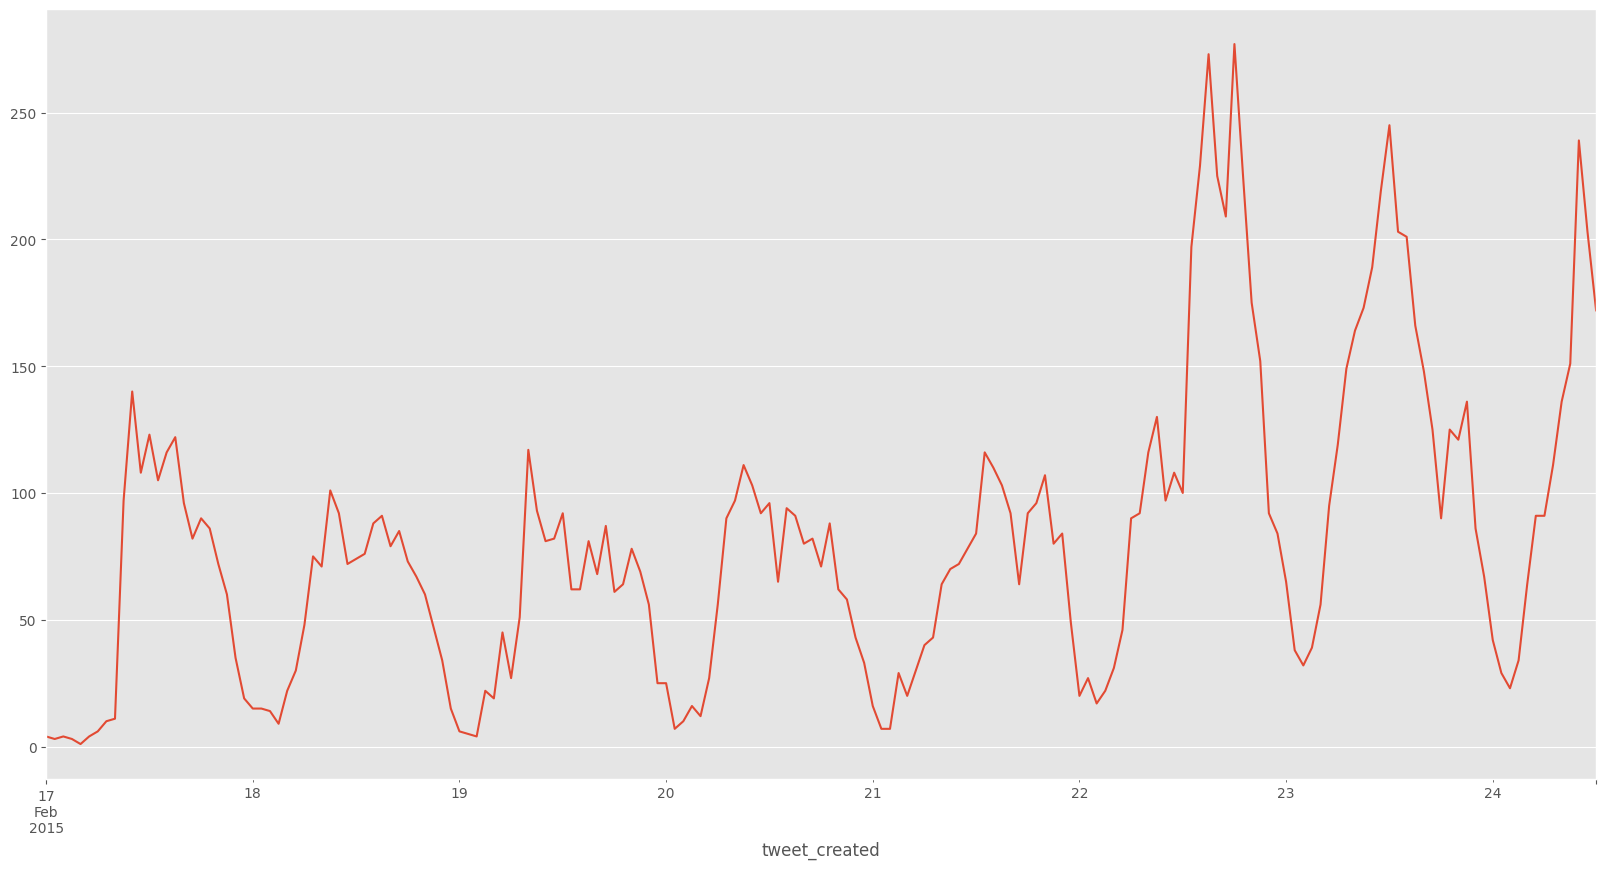

In [193]:
# Visualize the time series
time_hourly['Frequency'].plot()

##### **Step 3: Stationarity Check**

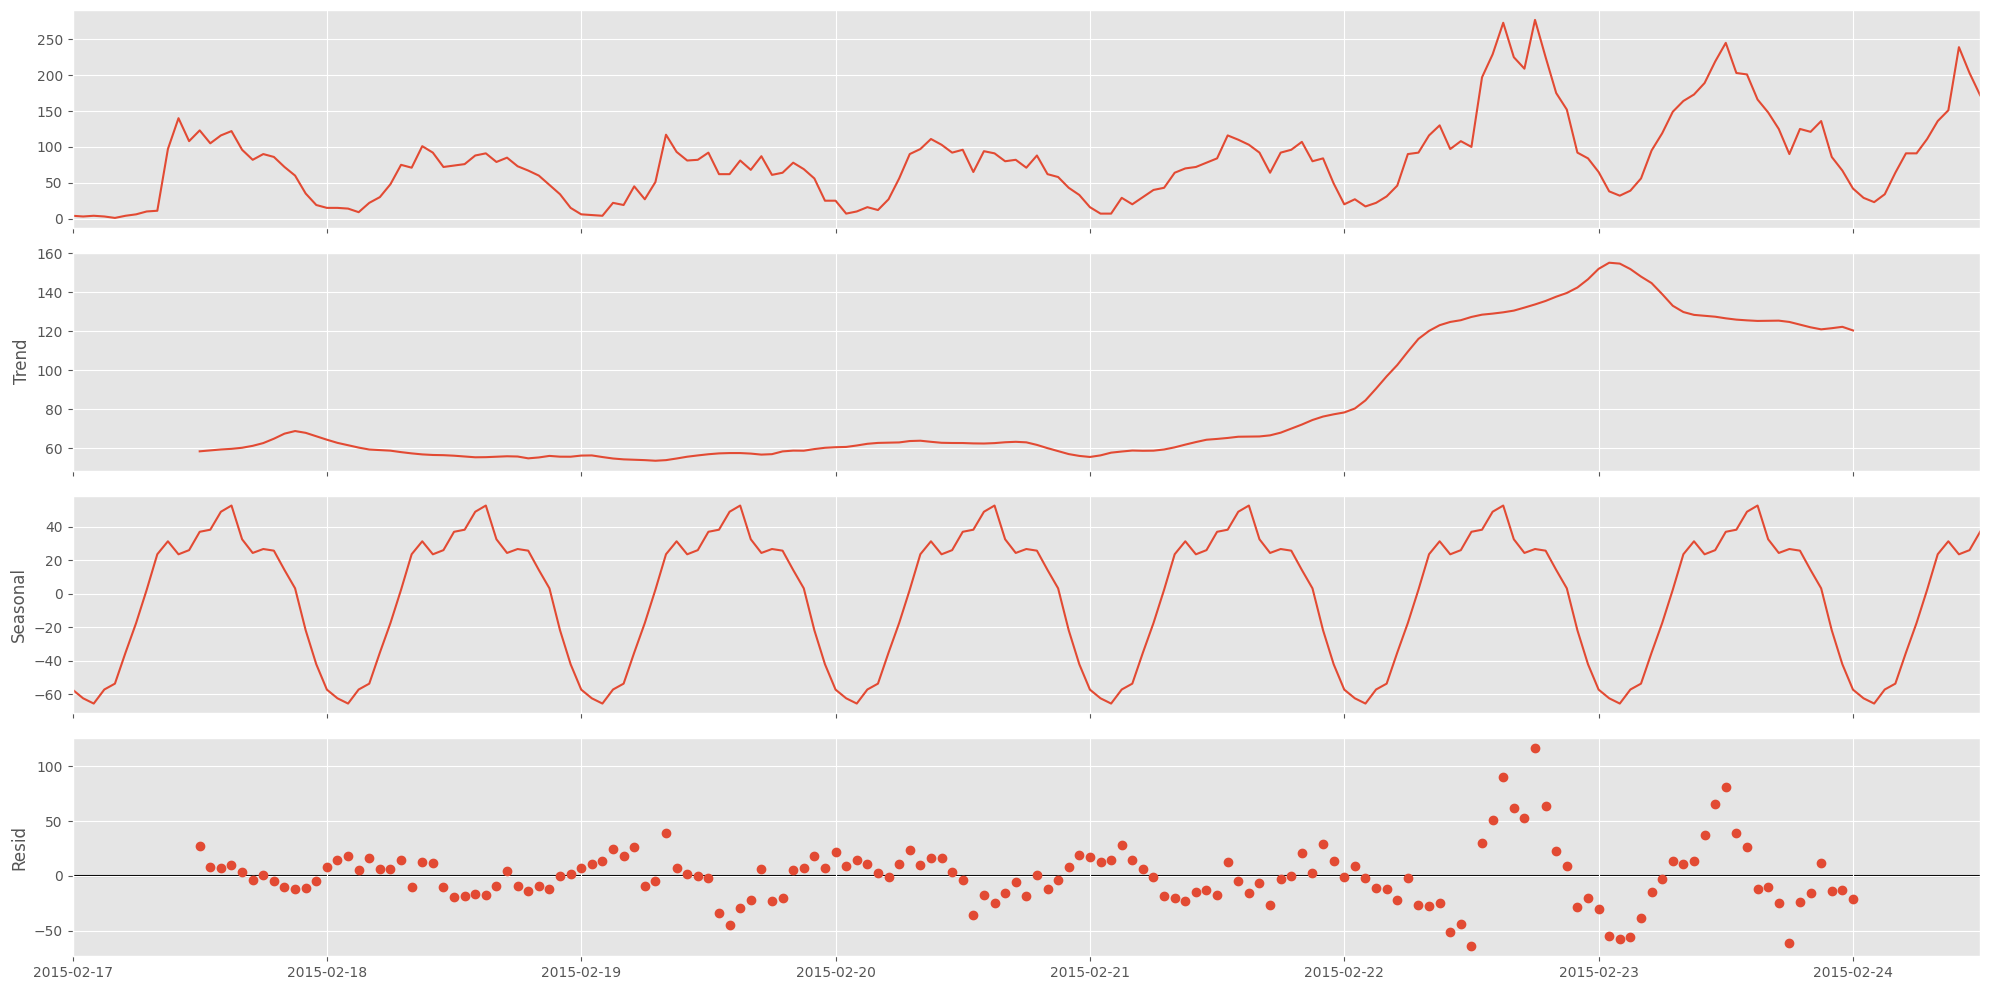

In [194]:
decomposition = sm.tsa.seasonal_decompose(time_hourly, model='additive')
fig = decomposition.plot()
plt.show()

In [195]:
adftest = adfuller(time_hourly)
print('pvalue of adfuller test is',adftest[1])

pvalue of adfuller test is 2.3969325318762526e-05


a low pvalue implies series is Stationary(lower than 0.05)
a high pvalue non stationary(>0.05).

This tells us that the data is stationary.

##### **Step 4: Train-Test Split**  

Split the dataset into a training set and a test set. The training set will be used to train the time series model, while the test set will be used for validation. The split can be performed based on a specific date or using a ratio of the dataset size.

In [196]:
train_size = int(len(time_hourly) * 0.8)  # 80% for training
train_data = time_hourly[:train_size]
test_data = time_hourly[train_size:]

##### **Step 5: Hyperparameter Selection**

For my model we chose the ARIMA model, to make this successful we need to select the best hyperparameters for p d q. To do this we will create a custom for loop.

In [197]:
import itertools

In [198]:
p=range(0,8)
q=range(0,8)
d=range(0,2)

In [199]:
pdq_combination=list(itertools.product(p,d,q))

In [200]:
len(pdq_combination)

128

In [201]:
rmse=[]
order1=[]

In [202]:
for pdq in pdq_combination:
    try:
        model=ARIMA(train_data,order=pdq).fit()
        pred=model.predict(start=len(train_data),end=(len(time_hourly)-1))
        error=np.sqrt(mean_squared_error(test_data,pred))
        order1.append(pdq)
        rmse.append(error)
        
    except:
        continue

In [203]:
results=pd.DataFrame(index=order1,data=rmse,columns=['RMSE'])

In [204]:
results.to_csv('ARIMA_results.csv')

The optimal ARIMA is (4,1,5)

##### **Step 5: Choosing and Training a Time Series Model**  

In [205]:
# model selection
model = sm.tsa.ARIMA(train_data['Frequency'], order=(4, 1, 5)) 

In [206]:
# Model Training
fitted_model = model.fit()

In [207]:
# Model Validation
predictions = fitted_model.predict(start=test_data.index[0], end=test_data.index[-1])

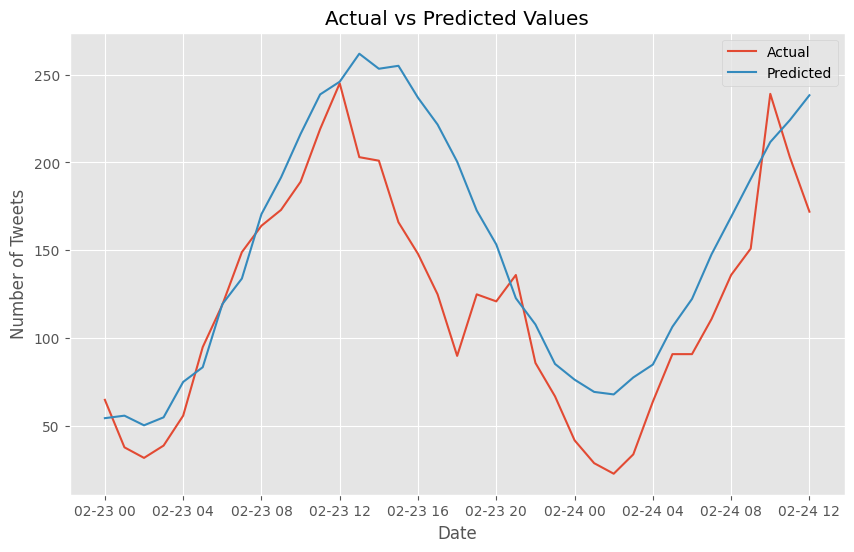

In [208]:
# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [209]:
# Compare predictions with actual values in the test set
mse = ((predictions - test_data['Frequency']) ** 2).mean()
rmse = mse ** 0.5
mae = abs(predictions - test_data['Frequency']).mean()

In [210]:
# Model Refinement

# Example: Refine the model by changing the order to ARIMA(2, 1, 1)
refined_model = sm.tsa.ARIMA(train_data['Frequency'], order=(2, 1, 1))
refitted_model = refined_model.fit()
ref_predictions = refitted_model.predict(start=test_data.index[0], end=test_data.index[-1])

##### **Step 6: Model Evaluation**

In [211]:
# Print evaluation metrics
print("Initial Model:")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

Initial Model:
MSE: 1868.2882107234595
RMSE: 43.22369964178748
MAE: 34.24779183815559


#### **c.	Use the model to make a forecast for one week into the future. Note that if you have resampled the data, you may choose a different forecast period, where appropriate.**

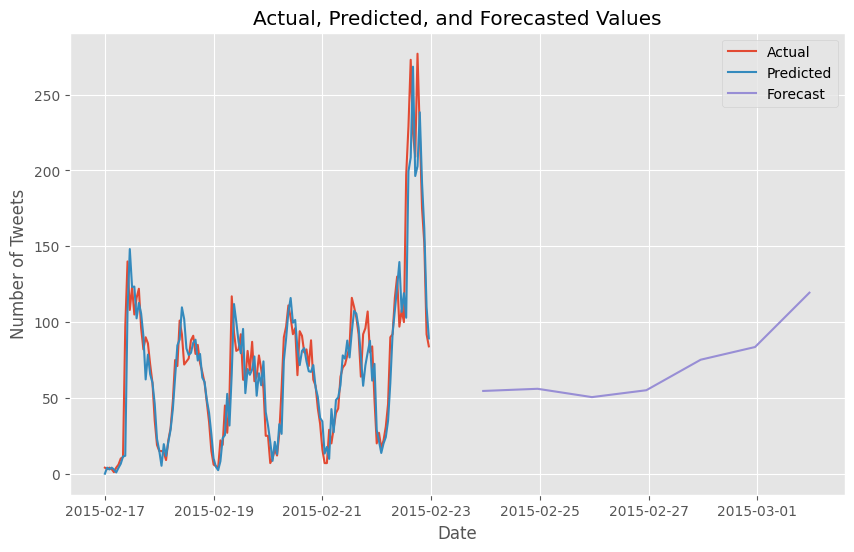

                                               Date    Forecast
2015-02-23 00:00:00-08:00 2015-02-23 23:00:00-08:00   54.589408
2015-02-23 01:00:00-08:00 2015-02-24 23:00:00-08:00   56.010720
2015-02-23 02:00:00-08:00 2015-02-25 23:00:00-08:00   50.523106
2015-02-23 03:00:00-08:00 2015-02-26 23:00:00-08:00   55.064988
2015-02-23 04:00:00-08:00 2015-02-27 23:00:00-08:00   75.192178
2015-02-23 05:00:00-08:00 2015-02-28 23:00:00-08:00   83.564358
2015-02-23 06:00:00-08:00 2015-03-01 23:00:00-08:00  119.395002


In [212]:
# Fit the ARIMA model
model = ARIMA(train_data, order=(4, 1, 5))
fitted_model = model.fit()

# Make a forecast for one week into the future
forecast_period = 7
forecast = fitted_model.forecast(steps=forecast_period)

# Generate dates for the forecast period
last_date = train_data.index[-1]
start_date = last_date + pd.DateOffset(days=1)
forecast_dates = pd.date_range(start=start_date, periods=forecast_period, freq='D')

# Plot the actual data, predictions, and forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data.values, label='Actual')
plt.plot(fitted_model.predict(), label='Predicted')
plt.plot(forecast_dates, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Actual, Predicted, and Forecasted Values')
plt.legend()
plt.show()

# Print the forecasted values and dates
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})
print(forecast_df)

#### **d. Explain your results and conclusions, as well as discuss any limitations to your analysis.**

**Model Performance:** The initial model exhibits a moderate level of performance. The MSE, RMSE, and MAE values indicate that, on average, the model's predictions deviate from the actual values by around 43 units. While the model's performance may be considered acceptable, it's important to evaluate it within the context of the dataset and the specific problem being addressed.

**Accuracy of Forecasts:** The forecasted values might reasonably approximate the actual values, but the deviation indicated by the evaluation metrics suggests that the model's predictions are not entirely accurate. The forecasts could be improved by refining the model or exploring alternative approaches.

**Limitations:** Several limitations should be considered when interpreting the results:
- **Data Quality:** The accuracy of the forecasts heavily relies on the quality and reliability of the input data. If the data contains inconsistencies, missing values, or outliers, it may affect the model's performance.

- **Model Selection:** The choice of the ARIMA model and its hyperparameters might not be optimal for this specific dataset. Other models, such as SARIMA or SARIMAX, or alternative approaches like machine learning algorithms, may yield better results.

**Assumptions:** Time series models assume that the underlying patterns and relationships observed in historical data will persist in the future. However, if there are sudden changes, regime shifts, or unforeseen events that impact the data, the model's performance may be compromised.

### **Part 2: Text Analysis - Analysing the Tweet Content** 

PlaneSimple is interested not just in how many tweets there are, but what people are talking about.  

#### **a. Briefly explain why Text Analysis may be useful in this situation and describe your analysis objective.**

Text analysis can be highly useful for gaining insights and understanding the sentiment, topics, and trends within the tweets. It can be trained to understand how customers feel in a positive and negative way .

#### **b. Train an appropriate model to perform Sentiment Analysis on the tweets.**

we will take a look at the variable “airline_sentiment_confidence” to see if majority of the customer ratings are positive or negative.

In [213]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
# Product Scores
fig = px.histogram(df, x="airline_sentiment_confidence")
fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Sentiment Confidence')
fig.show()

From this we can see that most of the sentiment confidence is 100% confident.  

Now we can create multiple word clouds to show the most  used words in the reviews.

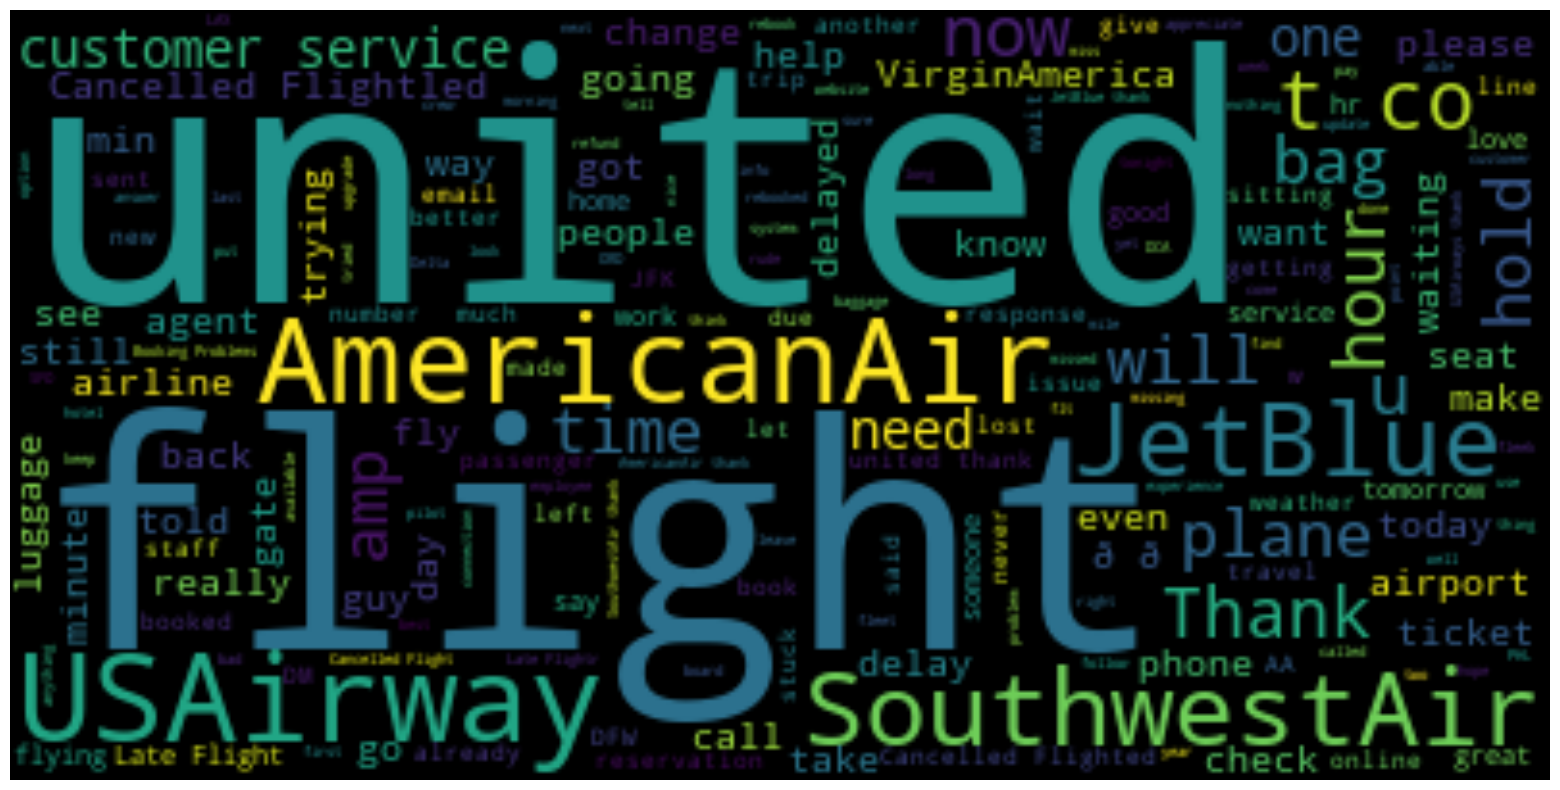

In [214]:
import nltk
from nltk.corpus import stopwords
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(review for review in df.text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

Some popular words that can be observed here include “Cancelled Flight,” “still,” “help,” and “time.” These words are mostly negative, also indicating that most reviews in the dataset could be negative sentiment.

Now let’s build wordclouds for each!

First, we will create two data frames — one with all the positive reviews, and another with all the negative reviews.

In [215]:
# split df - positive and negative sentiment:
positive = df[df['Score'] == 1]
negative = df[df['Score'] == -1]
neutral = df[df['Score'] == 0]

**Wordcloud — Positive Sentiment**

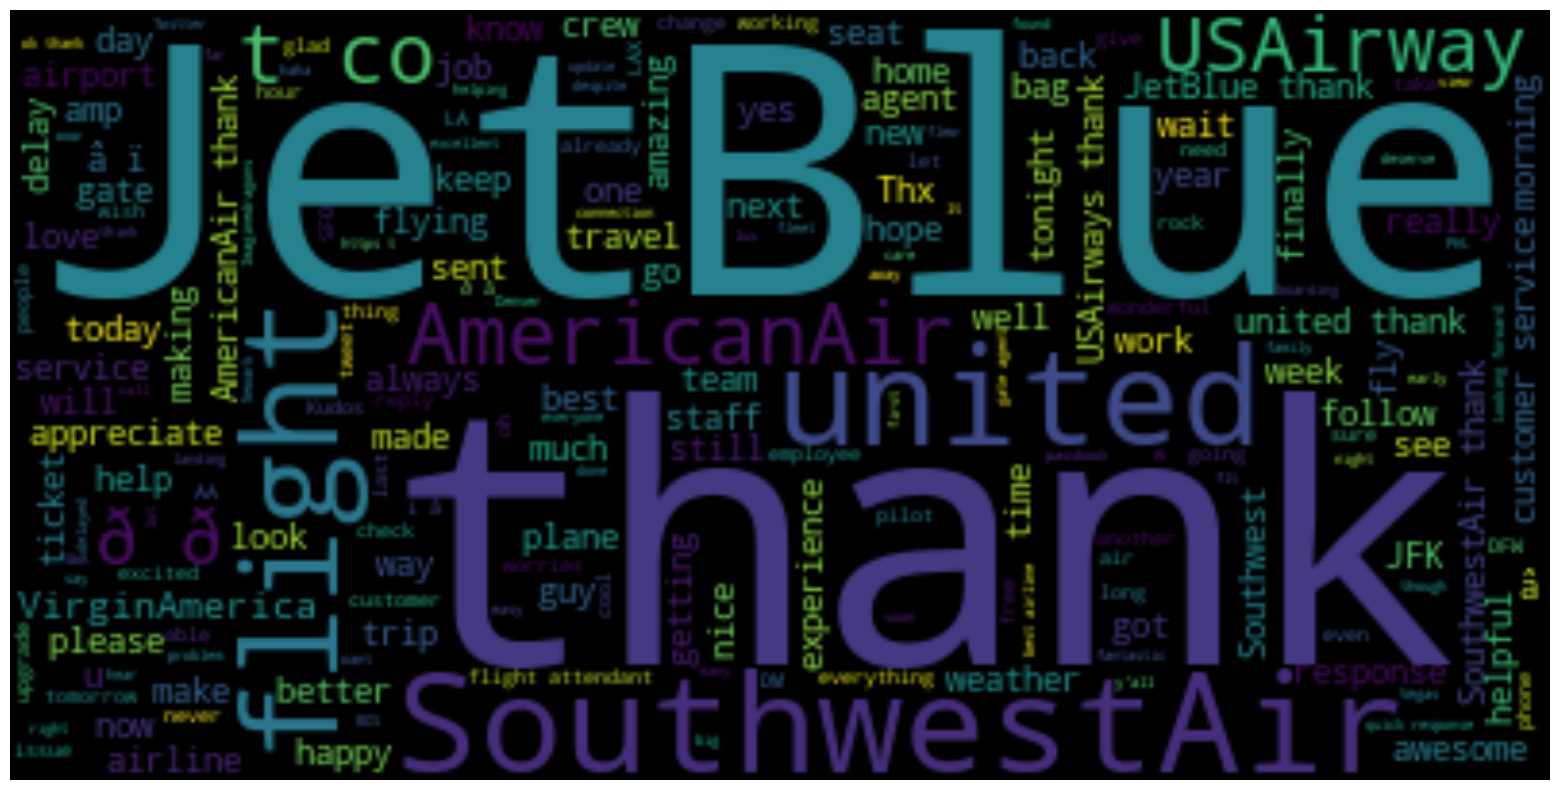

In [216]:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href","good","great"]) 
## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in positive.text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

**Wordcloud — Negative Sentiment**

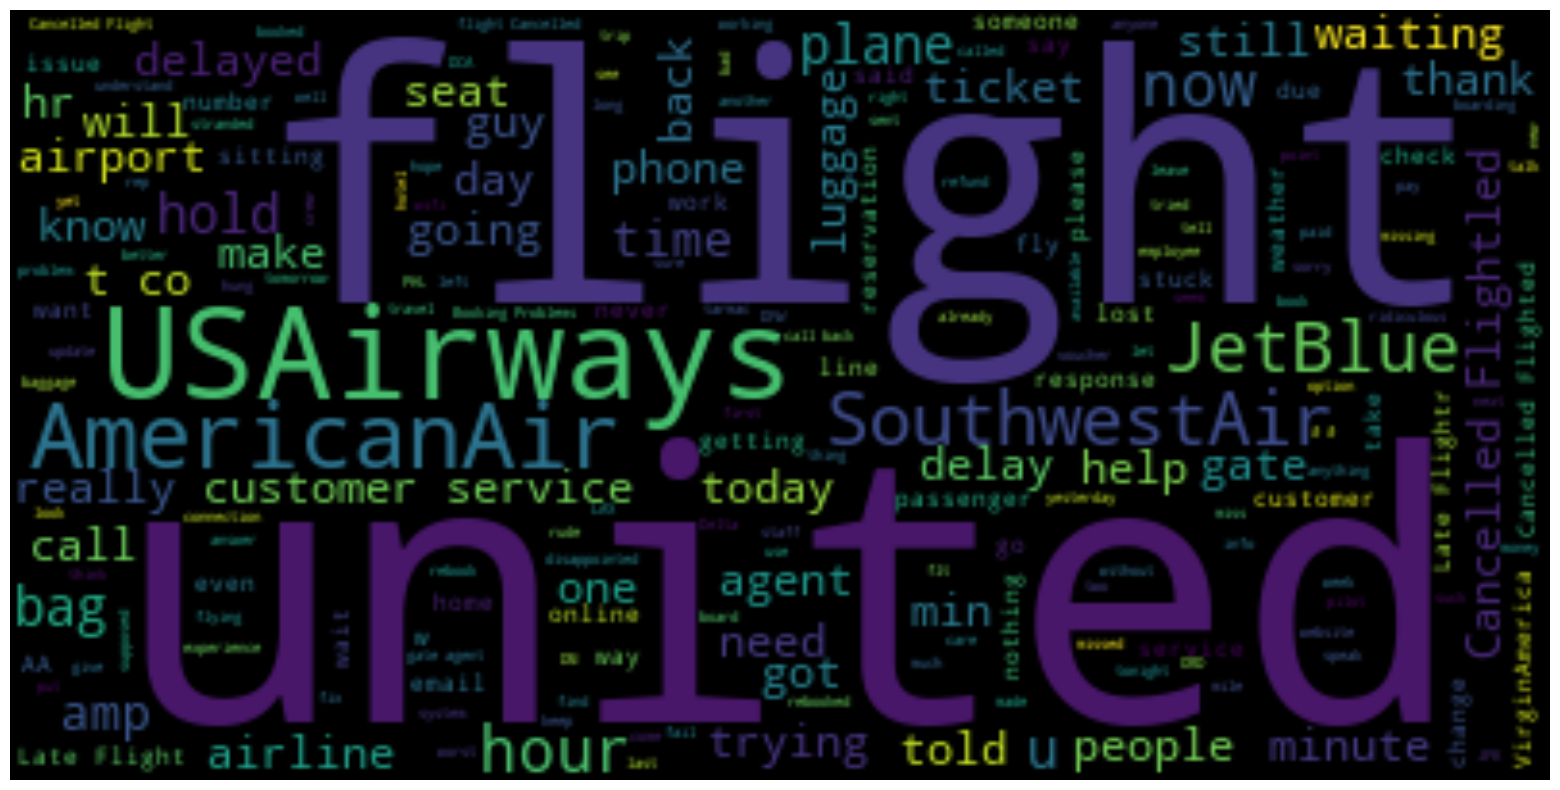

In [217]:
neg = " ".join(review for review in negative.text)
wordcloud3 = WordCloud(stopwords=stopwords).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud33.png')
plt.show()

**Wordcloud — Neutral Sentiment**

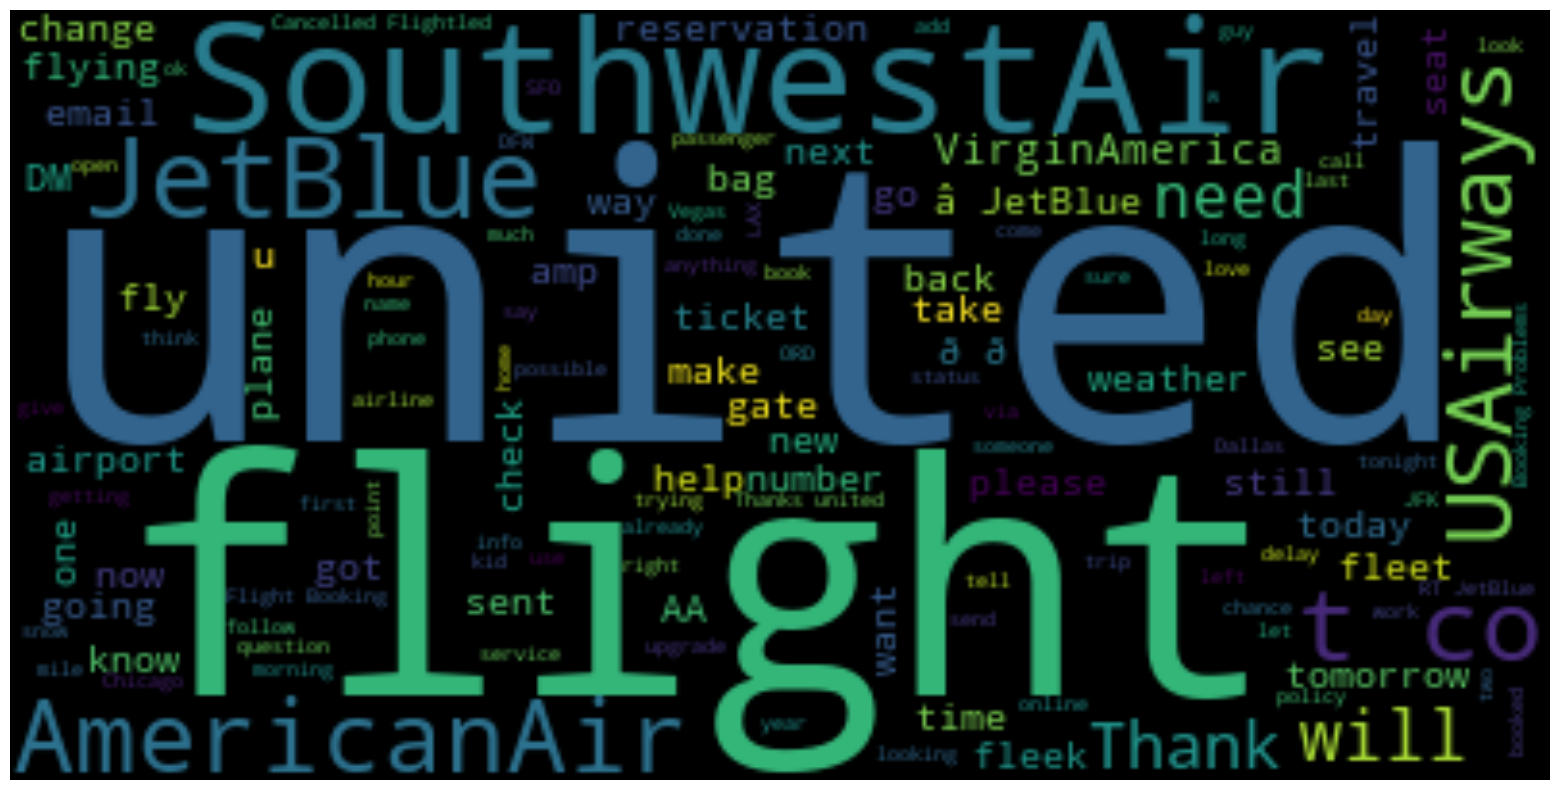

In [218]:
neu = " ".join(review for review in neutral.text)
wordcloud3 = WordCloud(stopwords=stopwords).generate(neu)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud33.png')
plt.show()

**Building the Model**

This model uses feedback as input. A prediction is then made as to whether the feedback will be positive or negative. 

This is a classification problem, so we'll train it with a simple logistic regression model.

There are a few steps we need to take:

**Data Cleaning**
We will be using the summary data to come up with predictions. First, we need to remove all punctuation from the data.

In [219]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',"@"))
    return final
df['text'] = df['text'].apply(remove_punctuation)


**Split the Dataframe**
The new data frame should only have two columns — “Summary” (the review text data), and “sentiment” (the target variable).

In [220]:
dfNew = df[['Score','text']]
dfNew.head()

Score                                               text
0      0                   VirginAmerica What dhepburn said
1      1  VirginAmerica plus you've added commercials to...
2      0  VirginAmerica I didn't today Must mean I need ...
3     -1  VirginAmerica it's really aggressive to blast ...
4     -1  VirginAmerica and it's a really big bad thing ...

We will now split the data frame into train and test sets. 80% of the data will be used for training, and 20% will be used for testing.

In [221]:
# random split train and test data
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

**Create a bag of words**
Next we  use the count vectorizer from the scikit-learn library. 

This turns the text in our dataframe into a bag-of-words model containing a sparse matrix of integers. The frequency of each word is counted and printed. 

We  need to transform the text into a bag-of-words model because the logistic regression algorithm cannot understand the text.

In [222]:
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['text'])
test_matrix = vectorizer.transform(test['text'])

**Import Logistic Regression**

In [223]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

**Split target and independent variables**

In [224]:
X_train = train_matrix
X_test = test_matrix
y_train = train['Score']
y_test = test['Score']

**Fit model on data**

In [225]:
lr.fit(X_train,y_train)

LogisticRegression()

**Make predictions**

In [226]:
predictions = lr.predict(X_test)

We have successfully created a simple logistic regression model and trained  data on it. We also made predictions using the model

**Testing**

In [227]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[1771,  197,   86],
       [ 153,  416,   63],
       [  59,   81,  319]])

In [228]:
print(classification_report(predictions,y_test))


              precision    recall  f1-score   support

          -1       0.89      0.86      0.88      2054
           0       0.60      0.66      0.63       632
           1       0.68      0.69      0.69       459

    accuracy                           0.80      3145
   macro avg       0.72      0.74      0.73      3145
weighted avg       0.80      0.80      0.80      3145



The overall accuracy is about 81%, so more processing would be required.

#### **c. Train an appropriate model to perform Topic Modelling on the tweets.**

##### **Data Cleaning**

We use the following function to clean our texts and return a list of tokens

In [229]:
import spacy
print(spacy.__version__)

3.5.3


In [230]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [231]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/brain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We use NLTK’s Wordnet to find the meanings of words, synonyms, antonyms, and more. In addition, we use WordNetLemmatizer to get the root word.

In [232]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to /Users/brain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Filter out stop words:

In [233]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/brain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now we can define a function to prepare the text for topic modelling:

In [234]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

Open the data, read it line by line, prepare the text for each line's LDA, and add it to the list. 

Now you can see how the text data is transformed.

In [235]:
import nltk

nltk.download('omw-1.4')
import random
text_data = []
for line in df['negativereason']:
    tokens = prepare_text_for_lda(line)
    if random.random() > .99:
        print(tokens)
        text_data.append(tokens)

[nltk_data] Downloading package omw-1.4 to /Users/brain/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['flight', 'booking', 'problem']
['comment']
['comment']
[]
['flight']
['customer', 'service', 'issue']
['flight', 'booking', 'problem']
['damage', 'luggage']
['luggage']
['luggage']
['customer', 'service', 'issue']
['flight']
['comment']
[]
['comment']
['flight']
[]
['comment']
['luggage']
['cancel', 'flight']
['longlines']
['flight']
['luggage']
['flight']
[]
['comment']
['flight']
['cancel', 'flight']
['comment']
['comment']
['flight']
['comment']
['comment']
['comment']
['comment']
['customer', 'service', 'issue']
['cancel', 'flight']
['comment']
['comment']
['flight']
['comment']
['flight']
['cancel', 'flight']
['comment']
['comment']
['customer', 'service', 'issue']
['flight', 'booking', 'problem']
['comment']
['comment']
['comment']
['flight']
['comment']
['customer', 'service', 'issue']
['flight']
['comment']
['flight', 'booking', 'problem']
['comment']
['flight']
[]
['comment']
[]
['flight', 'booking', 'problem']
['comment']
['comment']
['customer', 'service', 'issue']
['comme

**LDA with Gensim**

We first create a dictionary from the data, then convert it to a set of words and save the dictionary and corpus for future use.

In [236]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)

In [237]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [238]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

**Try 5 topics**

In [239]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')

In [240]:
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.311*"service" + 0.311*"customer" + 0.311*"issue" + 0.020*"complaint"')
(1, '0.310*"flight" + 0.308*"booking" + 0.308*"problem" + 0.013*"comment"')
(2, '0.954*"comment" + 0.004*"flight" + 0.004*"service" + 0.004*"issue"')
(3, '0.634*"longlines" + 0.031*"flight" + 0.031*"problem" + 0.031*"booking"')
(4, '0.560*"flight" + 0.202*"luggage" + 0.166*"cancel" + 0.040*"damage"')


In [241]:
new_doc = 'Practical Bayesian Optimization of Machine Learning Algorithms'
new_doc = prepare_text_for_lda(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)
print(new_doc_bow)
print(ldamodel.get_document_topics(new_doc_bow))

[]
[(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]


In [242]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.318*"flight" + 0.289*"problem" + 0.289*"booking" + 0.011*"comment"')
(1, '0.474*"comment" + 0.166*"issue" + 0.166*"service" + 0.166*"customer"')
(2, '0.487*"flight" + 0.182*"luggage" + 0.150*"cancel" + 0.069*"longlines"')


In [243]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.492*"longlines" + 0.133*"flight" + 0.132*"attendant" + 0.132*"complaint"')
(1, '0.327*"service" + 0.327*"customer" + 0.327*"issue" + 0.002*"comment"')
(2, '0.581*"flight" + 0.135*"problem" + 0.135*"booking" + 0.135*"cancel"')
(3, '0.977*"comment" + 0.002*"flight" + 0.002*"cancel" + 0.002*"luggage"')
(4, '0.881*"luggage" + 0.011*"flight" + 0.010*"booking" + 0.010*"problem"')
(5, '0.078*"flight" + 0.078*"cancel" + 0.078*"issue" + 0.078*"customer"')
(6, '0.396*"luggage" + 0.396*"damage" + 0.019*"comment" + 0.019*"flight"')
(7, '0.132*"service" + 0.132*"customer" + 0.132*"issue" + 0.061*"longlines"')
(8, '0.080*"service" + 0.080*"issue" + 0.080*"customer" + 0.078*"flight"')
(9, '0.077*"comment" + 0.077*"flight" + 0.077*"luggage" + 0.077*"customer"')


**pyLDAvis**

In [244]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

In [245]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [246]:
lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
lda_display3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)

In [247]:
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_display10 = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display10)

### **Part 3: Challenge** 

#### **a. Train an appropriate time series model to forecast positive tweet sentiment.**

##### **Step 1: Load and preprocess the dataset** 

In [248]:
# filtering to only positive sentiment
pos = df[df['airline_sentiment']=='positive']
# reviewing dataframe
pos.head(5)

tweet_id airline_sentiment  airline_sentiment_confidence  \
1   570301130888122368          positive                        0.3486   
6   570300616901320704          positive                        0.6745   
8   570299953286942721          positive                        0.6559   
9   570295459631263746          positive                        1.0000   
11  570289724453216256          positive                        1.0000   

   negativereason  negativereason_confidence         airline  \
1      no comment                        0.0  Virgin America   
6      no comment                        0.0  Virgin America   
8      no comment                        0.0  Virgin America   
9      no comment                        0.0  Virgin America   
11     no comment                        0.0  Virgin America   

   airline_sentiment_gold          name negativereason_gold  retweet_count  \
1                 neutral      jnardino          no comment              0   
6                 neutral    cjmcginnis          no comment              0   
8                 neutral      dhepburn          no comment              0   
9                 neutral    YupitsTate          no comment              0   
11                neutral  HyperCamiLax          no comment              0   

                                                 text  \
1   VirginAmerica plus you've added commercials to...   
6   VirginAmerica yes, nearly every time I fly VX ...   
8      virginamerica Well, I didn'tâ¦but NOW I DO -D   
9   VirginAmerica it was amazing, and arrived an h...   
11  VirginAmerica I &lt3 pretty graphics so much b...   

               tweet_created  tweet_date tweet_time  Score  random_number  
1  2015-02-24 11:15:59-08:00  2015-02-24   11:15:59      1       0.211318  
6  2015-02-24 11:13:57-08:00  2015-02-24   11:13:57      1      -0.520060  
8  2015-02-24 11:11:19-08:00  2015-02-24   11:11:19      1       0.030889  
9  2015-02-24 10:53:27-08:00  2015-02-24   10:53:27      1       0.039154  
11 2015-02-24 10:30:40-08:00  2015-02-24   10:30:40      1      -0.801309

In [249]:
# dropping columns
pos = pos[['tweet_created']]

# changing data type and grouping index to date/hour 
pos['tweet_created'] = pd.to_datetime(pos['tweet_created'])

pos['Positive_Tweets'] = 1

pos

tweet_created  Positive_Tweets
1     2015-02-24 11:15:59-08:00                1
6     2015-02-24 11:13:57-08:00                1
8     2015-02-24 11:11:19-08:00                1
9     2015-02-24 10:53:27-08:00                1
11    2015-02-24 10:30:40-08:00                1
...                         ...              ...
14623 2015-02-22 12:10:16-08:00                1
14625 2015-02-22 12:08:48-08:00                1
14628 2015-02-22 12:04:51-08:00                1
14630 2015-02-22 12:04:09-08:00                1
14635 2015-02-22 12:01:01-08:00                1

[2363 rows x 2 columns]

In [250]:
# Sort the DataFrame by the Time_created column in ascending order
pos = pos.sort_values('tweet_created', ascending=True)
pos.set_index('tweet_created', inplace=True)
pos.head(10)

Positive_Tweets
tweet_created                             
2015-02-17 04:03:09-08:00                1
2015-02-17 05:07:11-08:00                1
2015-02-17 05:40:59-08:00                1
2015-02-17 07:07:18-08:00                1
2015-02-17 07:53:02-08:00                1
2015-02-17 08:22:50-08:00                1
2015-02-17 08:31:10-08:00                1
2015-02-17 08:31:48-08:00                1
2015-02-17 08:36:06-08:00                1
2015-02-17 08:40:17-08:00                1

In [251]:
# Resampling / bucketing into 1 hour buckets to get some result..
pos_hourly = pos.resample('1H', label='right', closed='right').sum()
pos_hourly.head()

Positive_Tweets
tweet_created                             
2015-02-17 05:00:00-08:00                1
2015-02-17 06:00:00-08:00                2
2015-02-17 07:00:00-08:00                0
2015-02-17 08:00:00-08:00                2
2015-02-17 09:00:00-08:00               13

##### **Step 2: Time Series Analysis and Visualization**

<Axes: xlabel='tweet_created'>

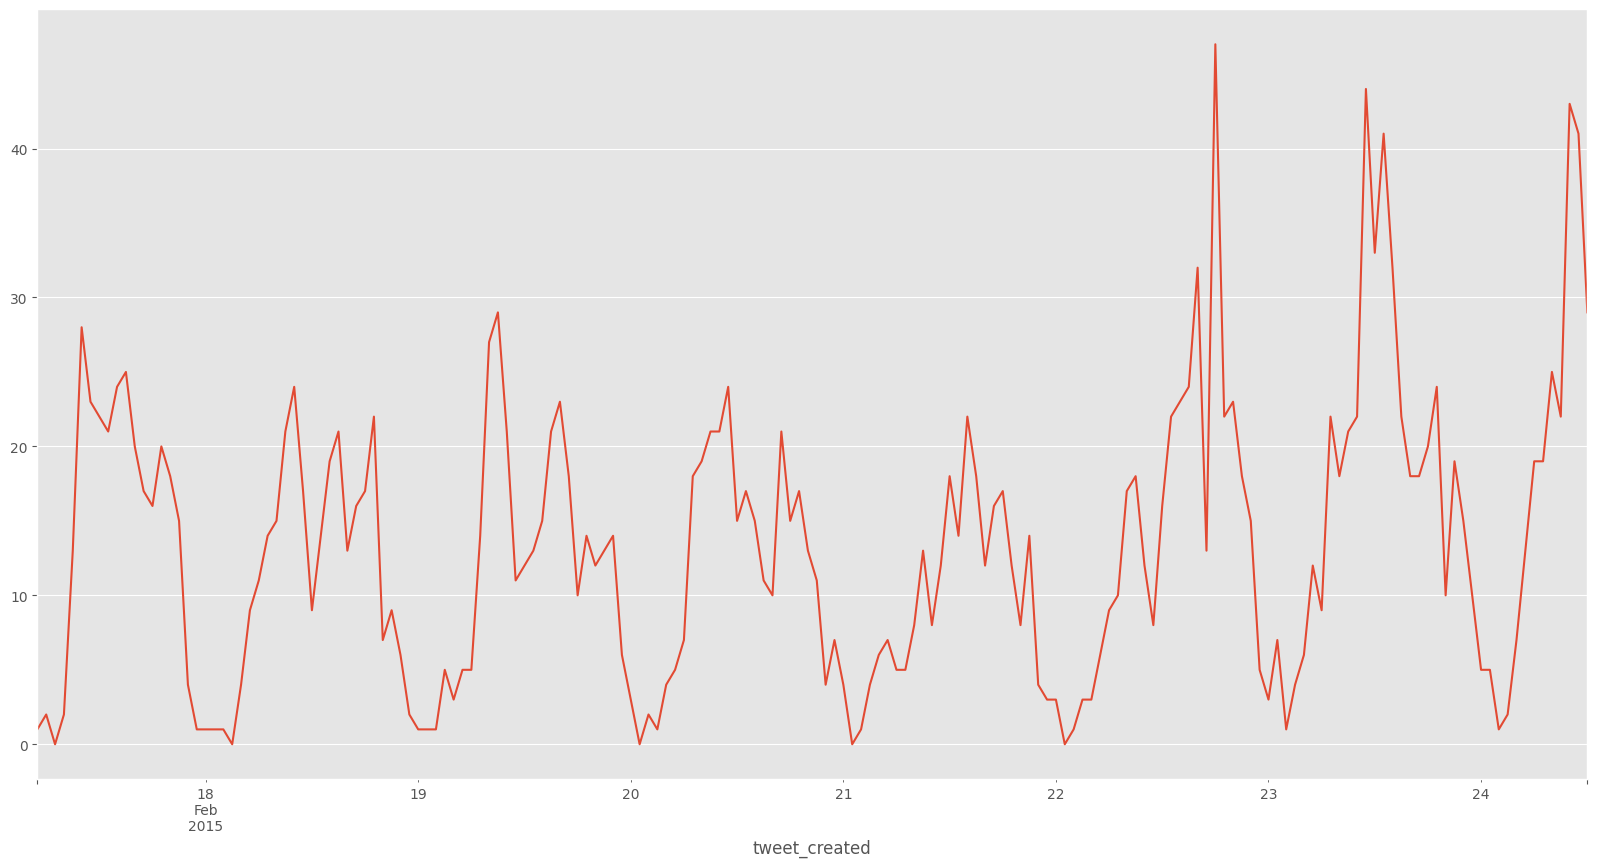

In [252]:
# Visualize the time series
pos_hourly['Positive_Tweets'].plot()

##### **Step 3: Stationarity Check**

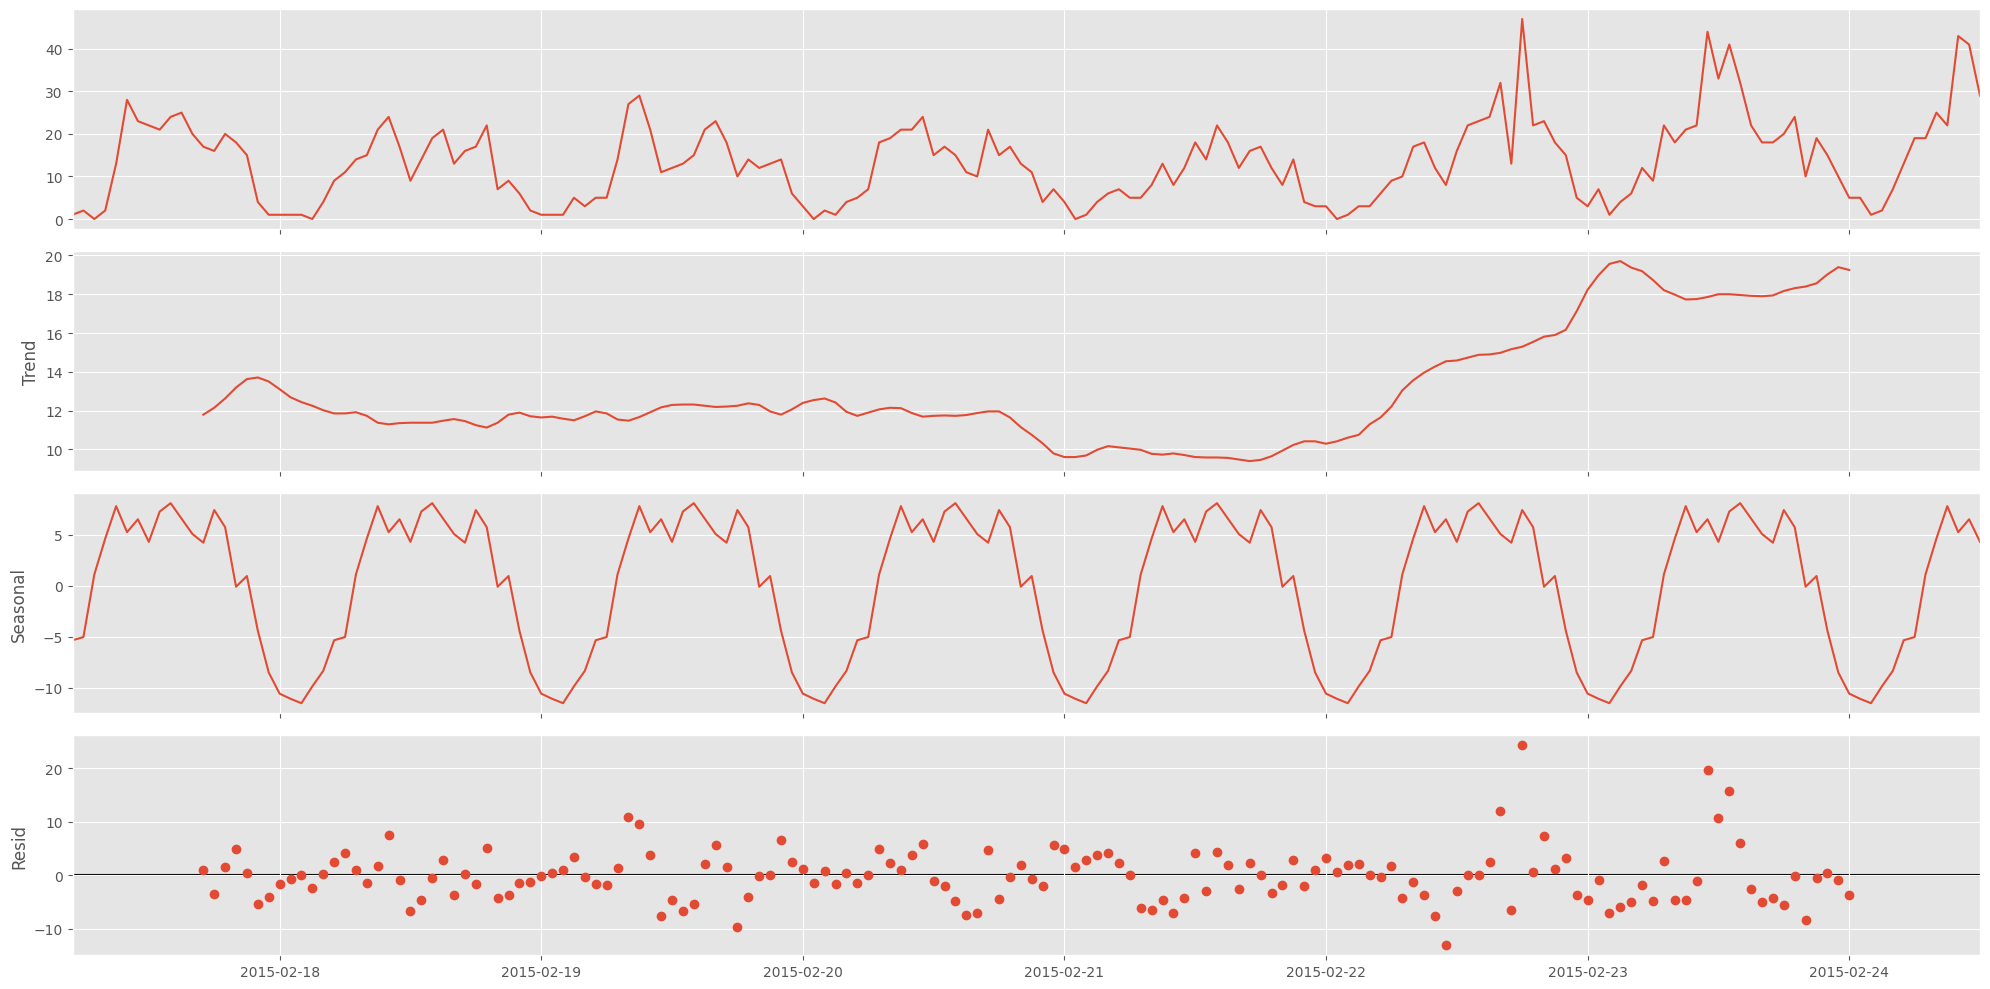

In [253]:
decomposition = sm.tsa.seasonal_decompose(pos_hourly, model='additive')
fig = decomposition.plot()
plt.show()

In [254]:
adftest = adfuller(pos_hourly)
print('pvalue of adfuller test is',adftest[1])

pvalue of adfuller test is 1.4643412333554414e-06


##### **Step 4: Train-Test Split**  

Split the dataset into a training set and a test set. The training set will be used to train the time series model, while the test set will be used for validation. The split can be performed based on a specific date or using a ratio of the dataset size.

In [255]:
train_size = int(len(pos_hourly) * 0.8)  # 80% for training
train_data = pos_hourly[:train_size]
test_data = pos_hourly[train_size:]

##### **Step 5: Hyperparameter Selection**

For my model we chose the ARIMA model, to make this successful we need to select the best hyperparameters for p d q. To do this we will create a custom for loop.

In [256]:
p=range(0,8)
q=range(0,8)
d=range(0,2)

In [257]:
pdq_combination=list(itertools.product(p,d,q))

In [258]:
len(pdq_combination)

128

In [259]:
rmse=[]
order1=[]

In [260]:
for pdq in pdq_combination:
    try:
        model=ARIMA(train_data,order=pdq).fit()
        pred=model.predict(start=len(train_data),end=(len(pos_hourly)-1))
        error=np.sqrt(mean_squared_error(test_data,pred))
        order1.append(pdq)
        rmse.append(error)
        
    except:
        continue

In [261]:
results=pd.DataFrame(index=order1,data=rmse,columns=['RMSE'])

In [262]:
results.to_csv('ARIMA_results_Chal.csv')

The optimal ARIMA is (2,0,6)

##### **Step 5: Choosing and Training a Time Series Model**  

In [263]:
# model selection
model = sm.tsa.ARIMA(train_data['Positive_Tweets'], order=(2, 0, 6)) 

In [264]:
# Model Training
fitted_model = model.fit()

In [265]:
# Model Validation
predictions = fitted_model.predict(start=test_data.index[0], end=test_data.index[-1])

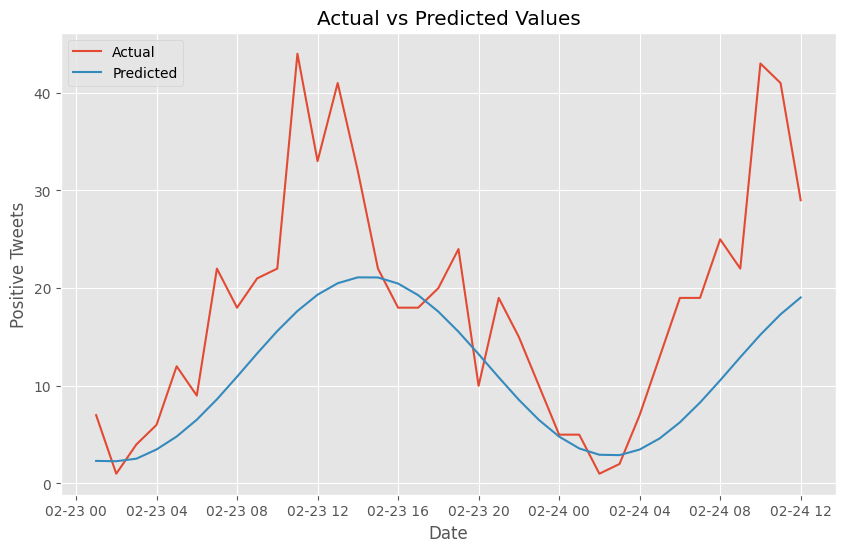

In [266]:
# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Positive Tweets')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [267]:
# Compare predictions with actual values in the test set
mse = ((predictions - test_data['Positive_Tweets']) ** 2).mean()
rmse = mse ** 0.5
mae = abs(predictions - test_data['Positive_Tweets']).mean()

##### **Step 6: Model Evaluation**

In [268]:
# Print evaluation metrics
print("Initial Model:")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

Initial Model:
MSE: 115.07882661614859
RMSE: 10.727479975098932
MAE: 7.974988819268832


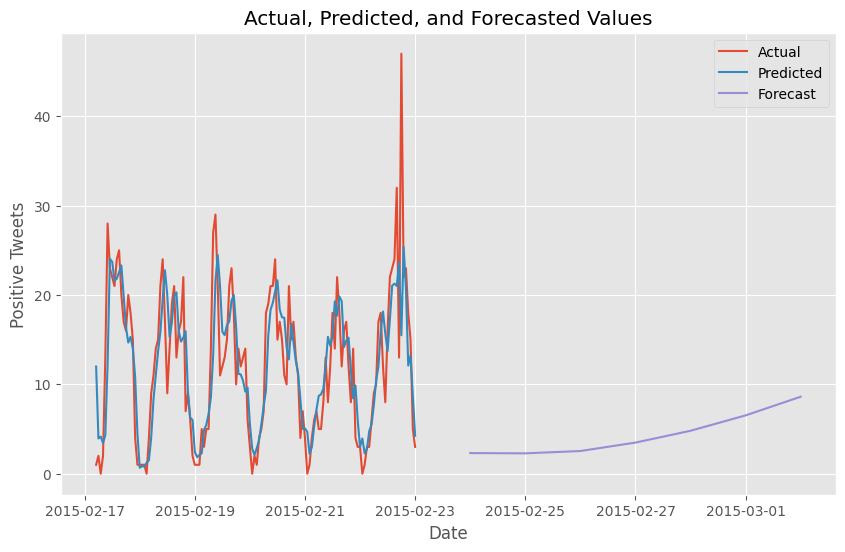

                                               Date  Forecast
2015-02-23 01:00:00-08:00 2015-02-24 00:00:00-08:00  2.310395
2015-02-23 02:00:00-08:00 2015-02-25 00:00:00-08:00  2.280914
2015-02-23 03:00:00-08:00 2015-02-26 00:00:00-08:00  2.539355
2015-02-23 04:00:00-08:00 2015-02-27 00:00:00-08:00  3.483589
2015-02-23 05:00:00-08:00 2015-02-28 00:00:00-08:00  4.807058
2015-02-23 06:00:00-08:00 2015-03-01 00:00:00-08:00  6.528587
2015-02-23 07:00:00-08:00 2015-03-02 00:00:00-08:00  8.616699


In [269]:
# Fit the ARIMA model
model = ARIMA(train_data, order=(2, 0, 6))
fitted_model = model.fit()

# Make a forecast for one week into the future
forecast_period = 7
forecast = fitted_model.forecast(steps=forecast_period)

# Generate dates for the forecast period
last_date = train_data.index[-1]
start_date = last_date + pd.DateOffset(days=1)
forecast_dates = pd.date_range(start=start_date, periods=forecast_period, freq='D')

# Plot the actual data, predictions, and forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data.values, label='Actual')
plt.plot(fitted_model.predict(), label='Predicted')
plt.plot(forecast_dates, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Positive Tweets')
plt.title('Actual, Predicted, and Forecasted Values')
plt.legend()
plt.show()

# Print the forecasted values and dates
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})
print(forecast_df)

##### **b. Train an appropriate time series model to forecast an appropriate topic of your choice.**

In [270]:
st = pd.read_csv('stock_prices.csv', parse_dates=['Date'], index_col='Date')

# Display the first few rows of the dataset
st.head()

A         AA      AAPL  ABBV        ABC       ABT  \
Date                                                                    
2003-07-31  13.790836  53.019848  1.019303   NaN  12.739487  9.022574   
2003-08-01  13.676599  51.759747  1.002379   NaN  12.579965  8.859362   
2003-08-04  13.682946  52.256149  1.025589   NaN  12.398233  8.850165   
2003-08-05  13.219654  51.206055  0.985455   NaN  12.111500  8.700747   
2003-08-06  13.060995  50.783653  0.949190   NaN  11.752071  8.873152   

                  ACN       ADBE        ADI       ADM  ...       XEL  \
Date                                                   ...             
2003-07-31  15.108545  16.333433  26.962475  9.694519  ...  7.946304   
2003-08-01  15.816516  16.268559  28.070812  9.561718  ...  7.858501   
2003-08-04  15.660917  16.523066  28.227112  9.591229  ...  7.803621   
2003-08-05  15.147444  16.183720  27.132978  9.532207  ...  7.699356   
2003-08-06  14.937387  15.749559  27.175615  9.620744  ...  7.748745   

                   XL       XLNX        XOM       XRAY        XRX  XYL  \
Date                                                                     
2003-07-31  53.450195  19.403030  24.283438  20.140688  23.011992  NaN   
2003-08-01  50.491951  19.898077  24.112812  19.770533  22.692390  NaN   
2003-08-04  51.500431  19.838972  24.303909  19.728891  21.605703  NaN   
2003-08-05  51.856777  19.225708  24.126451  19.405010  21.605703  NaN   
2003-08-06  52.643398  19.151808  24.399456  19.423517  21.818781  NaN   

                 YUM       ZION  ZNGA  
Date                                   
2003-07-31  8.275629  46.391441   NaN  
2003-08-01  8.272863  46.557457   NaN  
2003-08-04  8.239684  46.673660   NaN  
2003-08-05  8.167795  46.325050   NaN  
2003-08-06  8.037839  46.648762   NaN  

[5 rows x 479 columns]

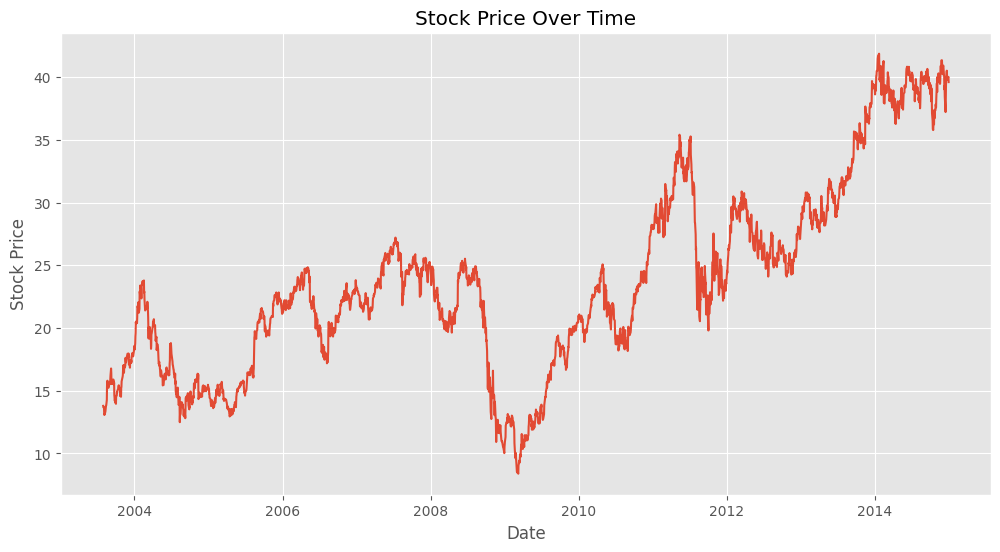

In [280]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(st.index, st['A'])
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Over Time')
plt.show()


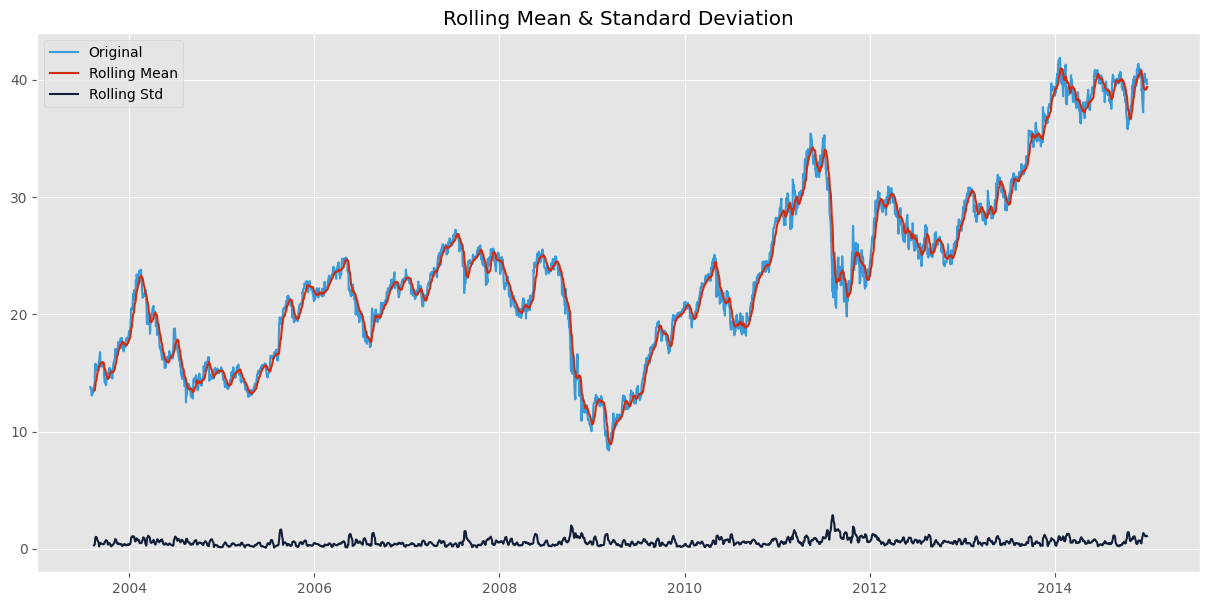

In [272]:
#Determine rolling statistics
st["rolling_avg"] = st["A"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
st["rolling_std"] = st["A"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(st["A"], color='#379BDB', label='Original')
plt.plot(st["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(st["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Extended Dickey-Fuller test** 
The extended Dickey-Fuller test is used to determine whether time series data is stationary or not. Similar to a t-test, we set a significance level before the test and use the resulting p-value to make inferences about the hypothesis.  

**Null hypothesis:** The data is not stationary.  
**Alternative hypothesis:** The data is stationary.   

For  data to be stationary (i.e. reject the null hypothesis), the ADF test must have: 

p-value <= significance level (0.01, 0.05, 0.10, etc.)  

If the p-value is greater than the significance level, we can say that  the data is probably not stationary.  

In the ADF test below, we can see that the p-value is 0.666568, which means the data is most likely not stationary.

In [273]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(st["A"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -1.216248
p-value                           0.666568
#Lags Used                       16.000000
Number of Observations Used    2859.000000
Critical Value (1%)              -3.432639
Critical Value (5%)              -2.862551
Critical Value (10%)             -2.567308
dtype: float64


In [274]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(st['A'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

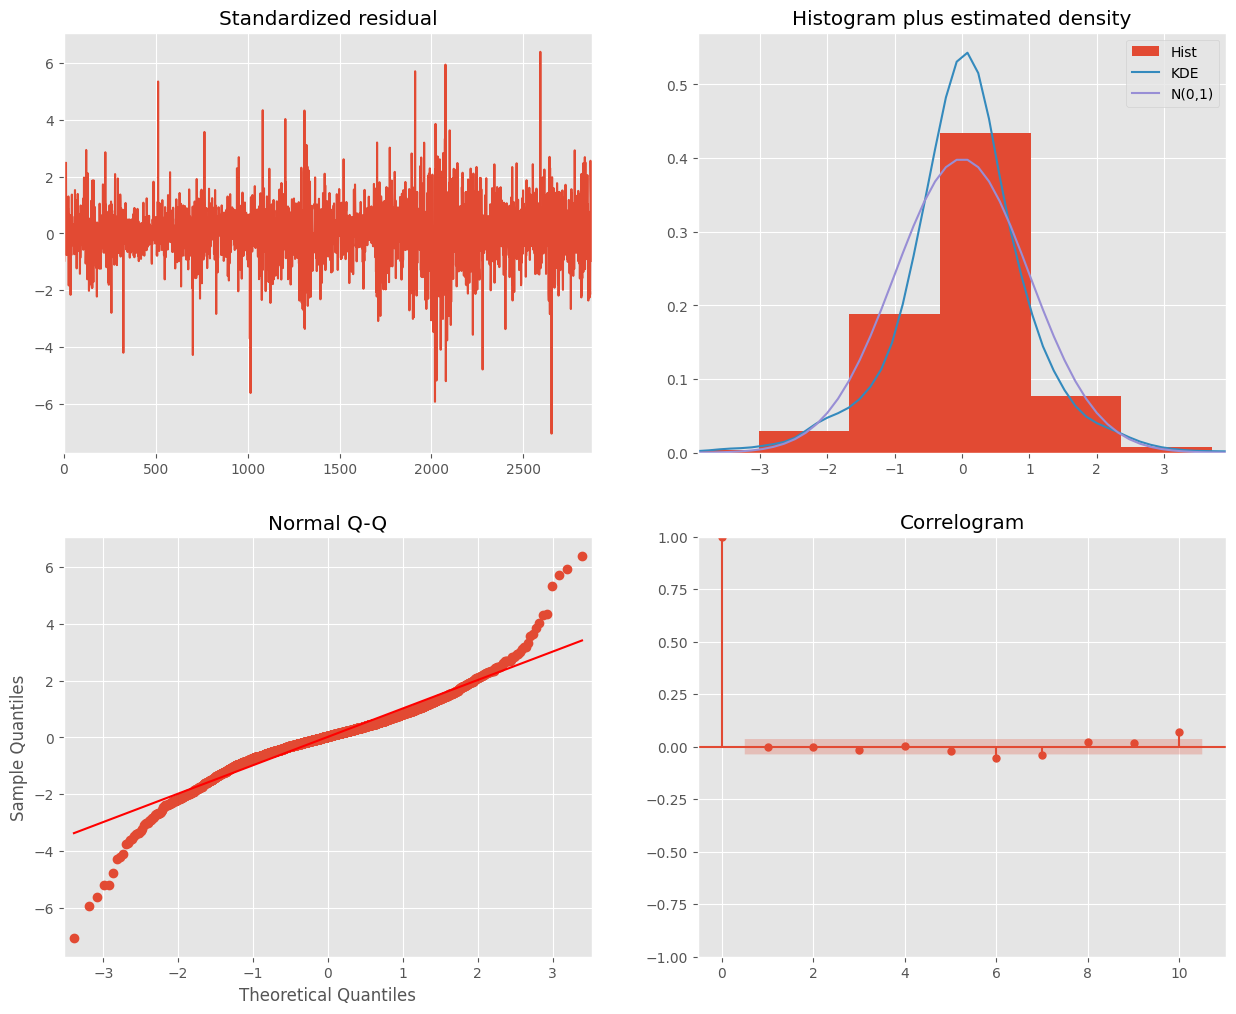

In [275]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

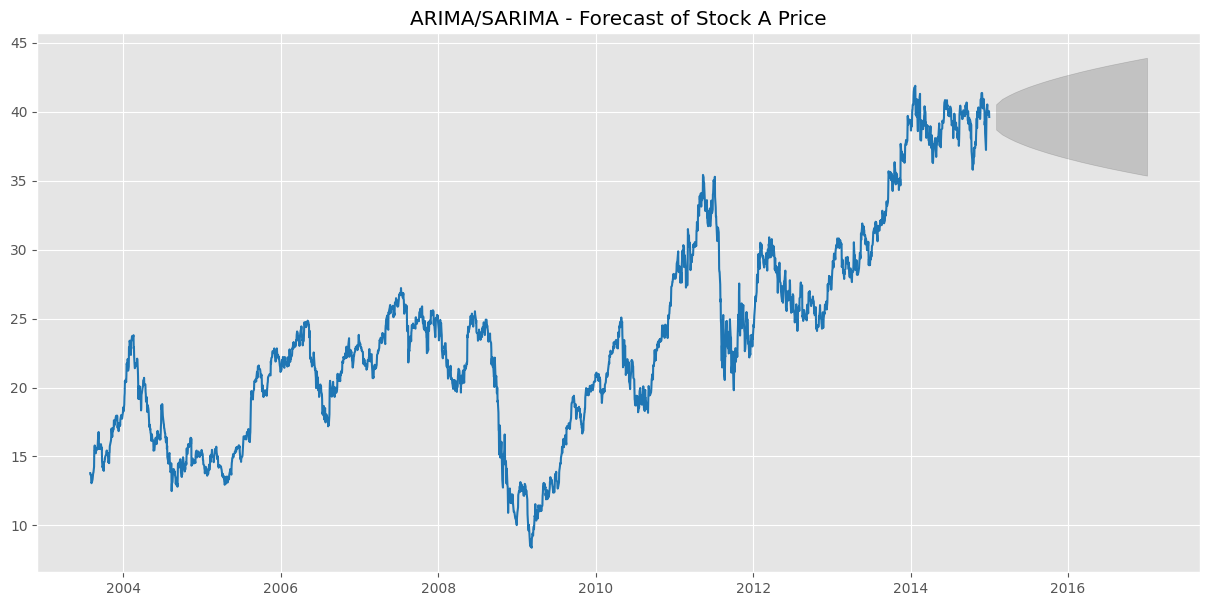

In [279]:

def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(st.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(st["A"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Stock A Price")
    plt.show()

forecast(ARIMA_model)

##### **c.  Explain your results and conclusions, as well as discuss any limitations to your analysis.**